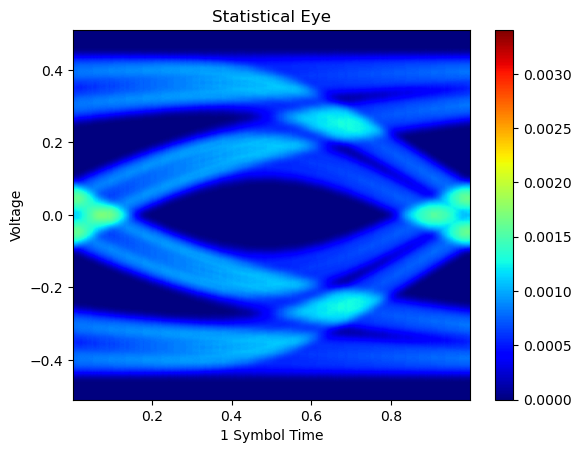

eye height: [-2.61998000e-01 -2.57186319e-01 -2.52374638e-01 -2.47562956e-01
 -2.42751275e-01 -2.37939594e-01 -2.33127913e-01 -2.28316231e-01
 -2.23504550e-01 -2.18692869e-01 -2.13881188e-01 -2.09069506e-01
 -2.04257825e-01 -1.99446144e-01 -1.94634463e-01 -1.89822781e-01
 -1.85011100e-01 -1.80567288e-01 -1.76123475e-01 -1.71679663e-01
 -1.67235850e-01 -1.62792038e-01 -1.58348225e-01 -1.53904413e-01
 -1.49460600e-01 -1.45016788e-01 -1.40572975e-01 -1.36129163e-01
 -1.31685350e-01 -1.27241538e-01 -1.22797725e-01 -1.18353913e-01
 -1.13910100e-01 -1.09876338e-01 -1.05842575e-01 -1.01808813e-01
 -9.77750500e-02 -9.37412875e-02 -8.97075250e-02 -8.56737625e-02
 -8.16400000e-02 -7.76062375e-02 -7.35724750e-02 -6.95387125e-02
 -6.55049500e-02 -6.14711875e-02 -5.74374250e-02 -5.34036625e-02
 -4.93699000e-02 -4.57958713e-02 -4.22218425e-02 -3.86478138e-02
 -3.50737850e-02 -3.14997563e-02 -2.79257275e-02 -2.43516988e-02
 -2.08126700e-02 -1.73142663e-02 -1.38158625e-02 -1.03174588e-02
 -6.81905500e

<function matplotlib.pyplot.show(close=None, block=None)>

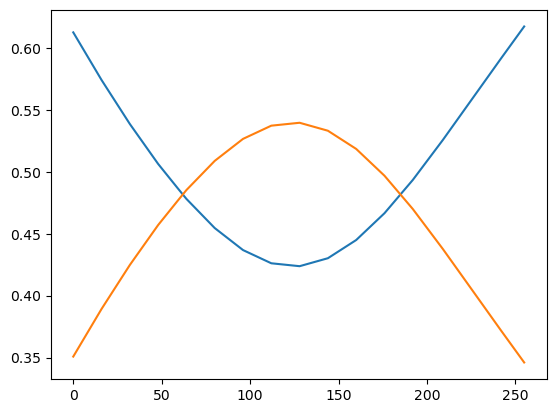

In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
N = 16
M = 2

def read_time_voltage_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith('#'):
                if not data:  # 第一行表示名称
                    data.append(('Name', line))
                else:
                    time, voltage = line.split()
                    data.append((float(time), float(voltage)))
    return data

def locate_main_cursor(time,voltage,N):
    # 找到波形的max峰值的位置
    voltage1 = voltage.tolist()
    max_voltage = max(voltage1)
    max_voltage_index = voltage1.index(max_voltage)
    max_voltage_time = time[max_voltage_index]
    ui_diff = 1e6 #initial value of the difference
    ndx = max_voltage_index #initial value of the index
    # print(ndx)
    while(ui_diff > 0):
        ndx = ndx + 1
        ui_diff = voltage1[ndx] - voltage1[ndx - N]
    #matlab pulseRecoverClock.m
    # print(ui_diff,ndx)
    uidiffprior = voltage1[ndx-1] - voltage1[ndx - N-1]
    # print(uidiffprior)
    mclock = np.interp(0,[ui_diff,uidiffprior],[ndx,ndx-1])
    C = mclock - N/2
    # print(mclock)
    ###插值去找到更精确的位置
    ##############################
    main_cursor_index_right = ndx
    main_cursor_index_left = ndx - N   

    return main_cursor_index_left,main_cursor_index_right,C

def shift_pulse(voltages,nclockC,N):
    voltages = np.array(voltages)
    shift_1 = N-(nclockC%N)
    shifted_voltages = np.roll(voltages,shift_1-1)
    return shifted_voltages,shift_1
filename_ads = 'D:/research/transfer_learning/sbr/pulse_output.txt'  
#"D:/research/transfer_learning/sbr/sbr1.txt"
#D:/research/transfer_learning/sbr/pulse_output.txt
# filename_ads ="D:/research/transfer_learning/sbr/sbr1.txt"
data_ads = read_time_voltage_file(filename_ads)
times_1 = [entry[0] for entry in data_ads[1:]]  # time data，skip the name
voltages_1 = [entry[0] for entry in data_ads[1:]]  # voltage data，skip the name
# dc_v = -voltages_1[0]
# for i in range(len(voltages_1)):
#     voltages_1[i] += dc_v



# print(mc_left_index,mc_right_index)
# print(voltages_1[mc_left_index],voltages_1[mc_right_index])

sps = 256
nhigh = 2**11
t = np.arange(0,len(voltages_1))/N
t2 = np.arange(0,t[-1]+1/sps,1/sps)

Voltages_1 = np.interp(t2,t,voltages_1,left=voltages_1[0],right=voltages_1[-1])
pulseSize = Voltages_1.shape
# naggressors = pulseSize[1]-1


dc_v = -Voltages_1[0]
for i in range(len(Voltages_1)):
    Voltages_1[i] += dc_v
#time vector for plotting
th = np.arange(0,sps)/sps+1/sps/2
mc_left_index,mc_right_index,nclockA = locate_main_cursor(times_1,Voltages_1,sps)
nclockC = int(np.round(nclockA)-sps/2)

shifted_voltages,shift1 = shift_pulse(Voltages_1,nclockC,sps)
nsym = math.floor(len(shifted_voltages)/sps)

cursorNdx = (nclockC + shift1) / sps

mc_left_index = mc_left_index + shift1
mc_right_index = mc_right_index + shift1
# print(mc_left_index,mc_right_index)
# print(shifted_voltages[mc_left_index],shifted_voltages[mc_right_index])
main_cursor_v = shifted_voltages[mc_left_index:mc_right_index]
pre_cursor_v = shifted_voltages[0:mc_left_index]
post_cursor_v = shifted_voltages[mc_right_index:nsym*sps]
# pulseM = 
pre_cursor_v = pre_cursor_v.reshape(-1,sps)
# N = 16
nsym_post_cursor = math.floor(len(post_cursor_v)/sps) #向下取整
# nsym = math.floor(len(shifted_voltages)/N)
# sps = 256
# nhigh = 2^11
# t = np.arange(0,len(shifted_voltages))/N
# t2 = np.arange(0,t[-1],1/sps)

# shifted_voltages = np.interp(t2,t,shifted_voltages,left=shifted_voltages[0],right=shifted_voltages[-1])

post_cursor_v = post_cursor_v[0:sps*nsym_post_cursor].reshape(-1,sps)
pulseM = np.concatenate((pre_cursor_v,np.reshape(main_cursor_v,(1,256)),post_cursor_v),axis=0)
pulseM = pulseM.T
maxh = 1.05*np.max(np.sum(np.abs(pulseM),axis=1))
scale = maxh*2/nhigh
vh1 = np.arange(0,scale+maxh,scale)
vh = np.concatenate((-vh1[-1:0:-1],vh1))/2
vhlen = len(vh)
isOddmod = np.mod(M,2)
numHistEye = (M+isOddmod)//2
if isOddmod:
    mf = 2/(M-1)
    modFactors = np.append(np.arange(mf,1,mf),0)
    modScale = np.append(np.arange(1,numHistEye),0)
else:
    modFactors = np.arange(1/(M-1),1+1/(M-1),2/(M-1))
    modScale = np.arange(1,M,2)

histUprEye = np.zeros((vhlen,sps,numHistEye))
for ii in range(sps):
    for jj in range(numHistEye):
        diff_abs = np.abs(modFactors[jj]*pulseM[ii,int(cursorNdx)]-vh*2)
        ndx0 = np.argmin(diff_abs)
        histUprEye[ndx0,ii,jj] =  1
histUprXtalkEye = np.zeros((vhlen,sps,1,1))
quant_bitX_count = 0
naggressors = 1
###ISI contributors
for jj in range(sps):
    for ii in range(nsym):
    #    for nn in range(naggressors):
    #        xtalk_val
    #        if np.any(quant_bitX != 0):
        for nn in range(naggressors):    

            if nn == 0 and ii==int(cursorNdx):
                continue
            
            isiORxtalk_valx = modFactors[0]*pulseM[jj,ii]
            quant_bitX = np.round(modScale*isiORxtalk_valx/scale)
            #Convolve histogram with ISI 
            if np.any(quant_bitX!=0):
                for kk in range(numHistEye):
                    hist_slice = histUprEye[:,jj,kk]
                    hist_slice_out = np.zeros((np.size(hist_slice)))
                    for mm in range(numHistEye):
                        if modScale[mm]!=0:
                            hist_slice_out = hist_slice_out + 1/M*np.roll(hist_slice,int(quant_bitX[mm])) + 1/M*np.roll(hist_slice,int(-quant_bitX[mm]))
                        else:
                            #odd modulation 0 volt transition
                            hist_slice_out = hist_slice_out + 1/M*np.roll(hist_slice,0)
                        
                    histUprEye[:,jj,kk] = hist_slice_out
SymbolTime = 1e-10
histUpr = np.sum(histUprEye,axis=2)/numHistEye
stateye = (histUpr+np.flipud(histUpr))/2
cmap = plt.cm.jet  # 替换为相应的Matplotlib颜色映射

# 使用imagesc的Python等价 - imshow来显示图像
plt.imshow(stateye, extent=(th.min(), th.max(), vh.min(), vh.max()), cmap=cmap, aspect='auto')

# 添加colorbar
plt.colorbar()

# 添加轴标签和标题
plt.xlabel('1 Symbol Time')
plt.ylabel('Voltage')
plt.title('Statistical Eye')

# 显示图形
plt.show()

# 添加颜色条


# 显示图像
plt.show()
                



upperPattern_pre = pre_cursor_v < 0
lowerPattern_pre = pre_cursor_v > 0
upperPattern_post = post_cursor_v < 0
lowerPattern_post = post_cursor_v > 0
s0 = np.zeros((1,16))
s1 = np.zeros((1,16))

s1 = np.sum(pre_cursor_v * upperPattern_pre,axis=0) + np.sum(post_cursor_v * upperPattern_post,axis=0)+main_cursor_v

s0 = np.sum(pre_cursor_v * lowerPattern_pre,axis=0) + np.sum(post_cursor_v * lowerPattern_post,axis=0)
eh = s1 - s0
eh1 = max(eh)
print('eye height:',eh)
# s1= s1.T
# s0 = s0.T

# s0 = s0.reshape(1,1250)
# s1 = s1.reshape(1,1250)
# plt.plot(main_cursor_v)
plt.plot(s0)
plt.plot(s1)
plt.show

截取拖尾的起点是拖尾数据中第一个电压值偏离
稳定值超过10-5的点，终点是拖尾数据中电压值偏离稳定值小于10-5的点。

存在问题：1.crosstalk，将pulseM改成多维
2.未对stateye进行中值滤波